<a href="https://colab.research.google.com/github/yneha70/IIIT-AIML_Project_and_labs/blob/main/Module6_LLab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
batch_size_train = 128
batch_size_test = 128
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.60MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.30MB/s]


In [5]:
print('Training data shape : ', train_data.data.shape, train_data.targets.shape)
print('Testing data shape : ', test_data.data.shape, test_data.targets.shape)
classes = np.unique(train_data.targets.numpy())
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  torch.Size([60000, 28, 28]) torch.Size([60000])
Testing data shape :  torch.Size([10000, 28, 28]) torch.Size([10000])
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [6]:
def plot_data(images, labels, classes=None):
  figure = plt.figure(figsize=(9, 4))
  cols, rows = 5, 2
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(images), size=(1,)).item()
      img, label = images[sample_idx], labels[sample_idx]
      figure.add_subplot(rows, cols, i)
      if classes is not None:
        label = classes[label]
      plt.title('Label:' +str(label))
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

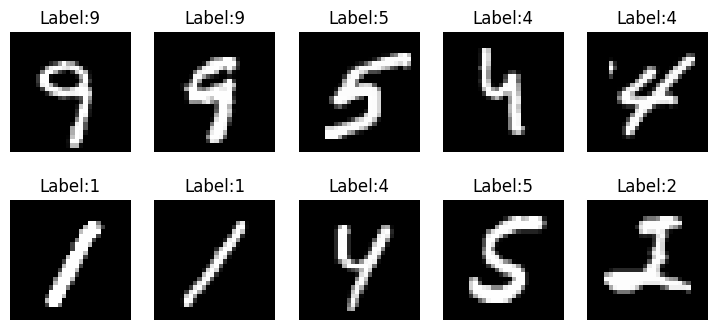

In [7]:
plot_data(train_data.data, train_data.targets.numpy())

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, 128)
        # output layer 10 classes
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) #activation
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        # flatten the output for FC layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = self.out(x)
        return output

In [9]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=3136, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
loss_func = nn.CrossEntropyLoss()

In [11]:
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [12]:
def train(num_epochs, model, train_loader, loss_func, optimizer):
  model.train()

  train_losses = []
  train_acc = []
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      output = model(images)
      loss = loss_func(output, labels)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, preds = torch.max(output, dim=1)

      correct = (preds.float() == labels).sum()
      running_acc += correct

      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [13]:
def test(model, test_loader):
  model.eval()
  test_acc = 0
  correct = 0
  for i, (images, labels) in enumerate(test_loader):
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)
      output = model(images)

      _, preds = torch.max(output, dim=1)
      correct += (preds == labels).sum()

  test_acc = correct / len(test_loader.dataset)
  print('Test Accuracy: {:.4f}'.format(test_acc*100))
  plot_data(images.data.cpu().numpy(), preds.data.cpu().numpy(), test_loader.dataset.classes)

In [14]:
num_epochs = 10
train_losses, train_acc = train(num_epochs, model, train_loader, loss_func, optimizer)

Epoch 1/10, Loss: 0.0115, Accuracy: 63.7583
Epoch 2/10, Loss: 0.0029, Accuracy: 89.0600
Epoch 3/10, Loss: 0.0022, Accuracy: 91.6233
Epoch 4/10, Loss: 0.0018, Accuracy: 93.1517
Epoch 5/10, Loss: 0.0015, Accuracy: 94.3717
Epoch 6/10, Loss: 0.0013, Accuracy: 95.3050
Epoch 7/10, Loss: 0.0011, Accuracy: 95.8450
Epoch 8/10, Loss: 0.0010, Accuracy: 96.3667
Epoch 9/10, Loss: 0.0009, Accuracy: 96.6967
Epoch 10/10, Loss: 0.0008, Accuracy: 97.0150


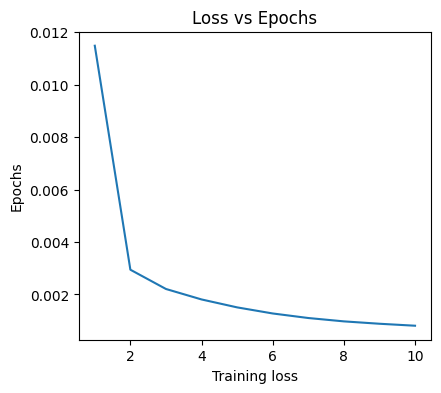

In [15]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
plt.show()

Test Accuracy: 97.2600


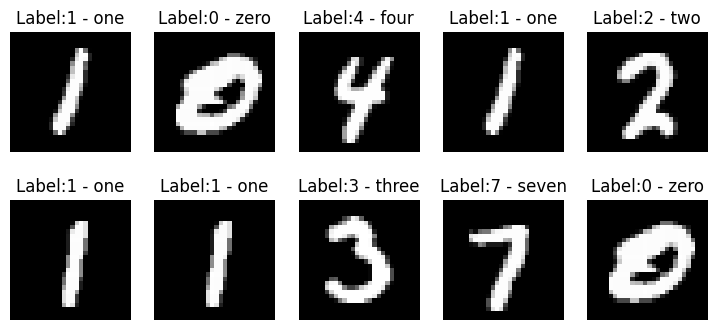

In [16]:
test(model, test_loader)

In [17]:
model_weights = []
conv_layers = []
model_children = list(model.children())
counter = 0
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [18]:
for weight, conv in zip(model_weights, conv_layers):
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([32, 1, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])


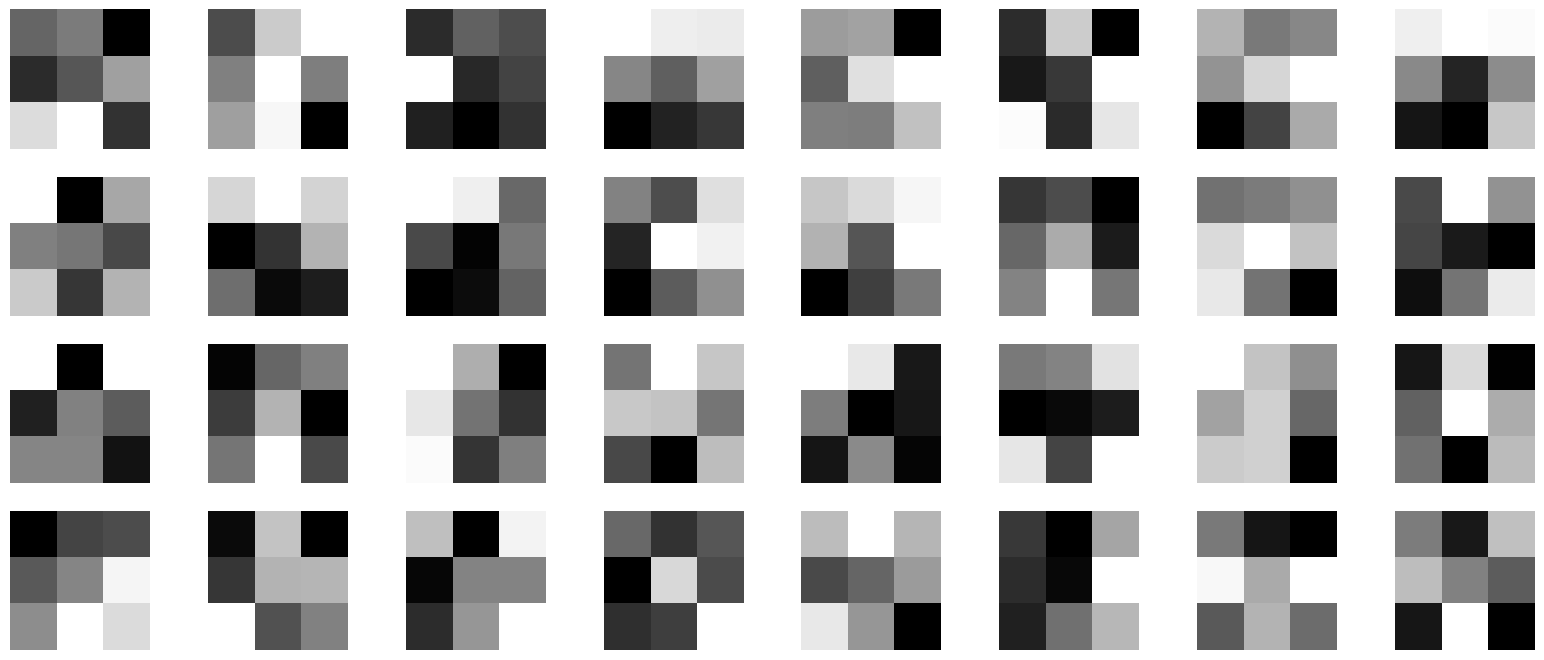

In [19]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8)
    plt.imshow(filter[0, :, :].data.cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

2
5
8
1
2
8
6
5
1
6
5
2
6
4
9
6
9
8
3
2
8
5
0
3


/tmp/ipython-input-1557531871.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 3))


1
2
7
1
7
7
4
7
3
7
0
4
4
8
7
7
7
0
9
0
5
2
1
7
8
4
9
4
8
2
1
7
4
8
4
8
6
5
4
8
4
7
1
4
9
7
4
9
3
1
4
0
5
8
2


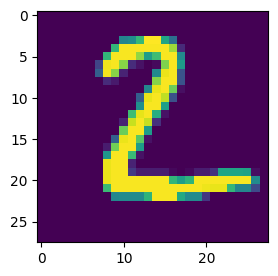

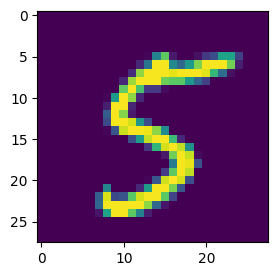

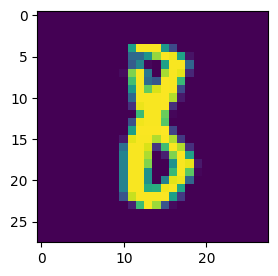

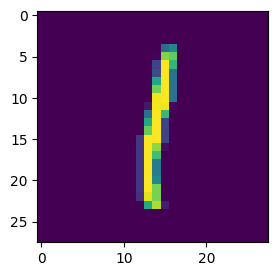

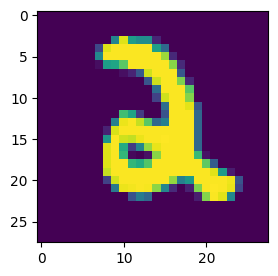

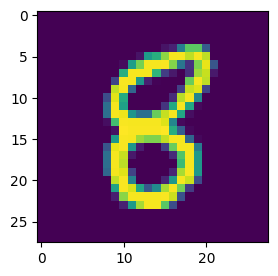

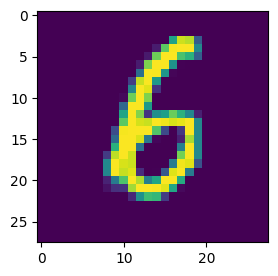

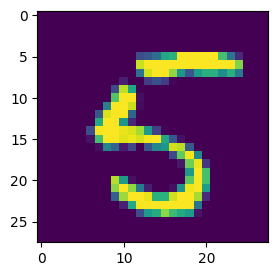

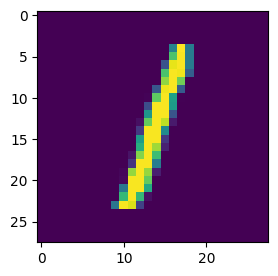

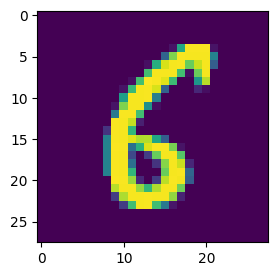

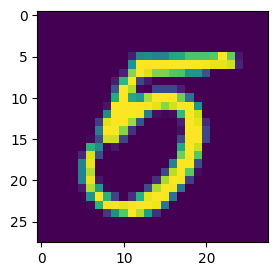

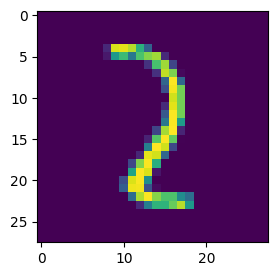

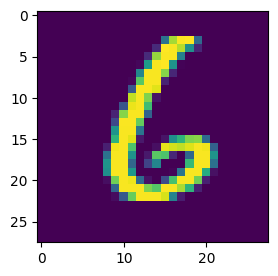

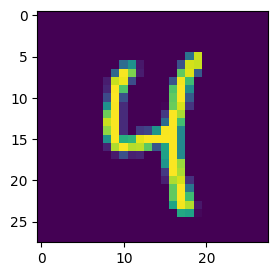

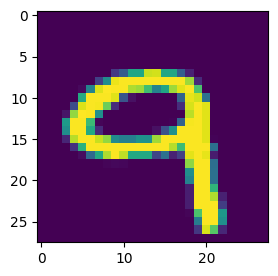

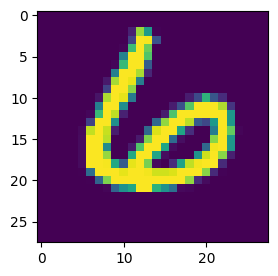

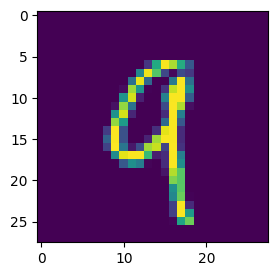

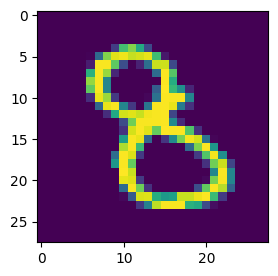

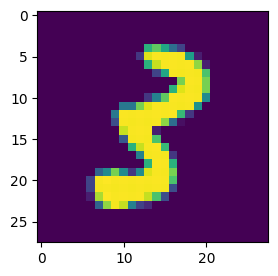

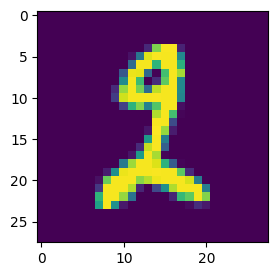

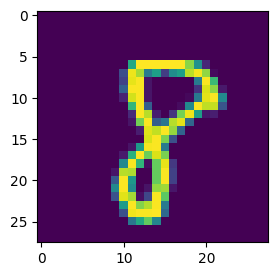

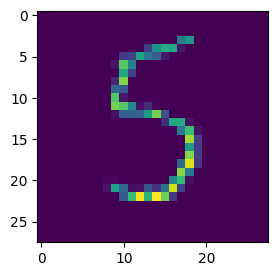

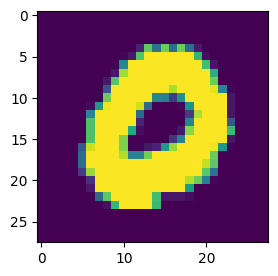

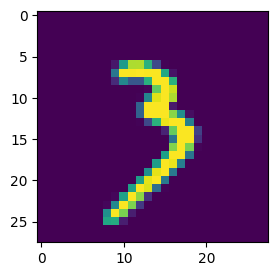

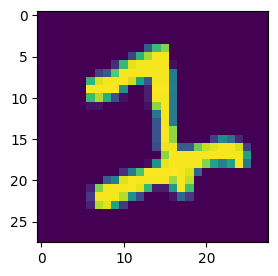

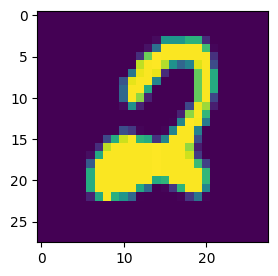

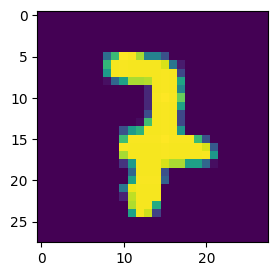

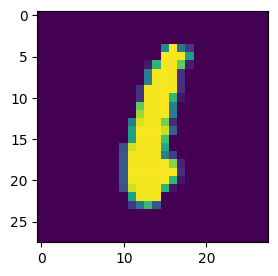

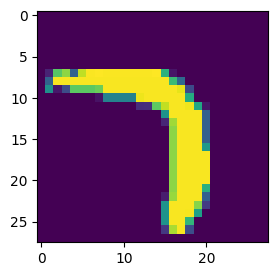

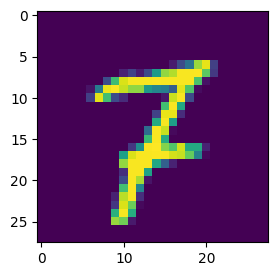

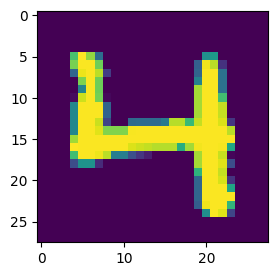

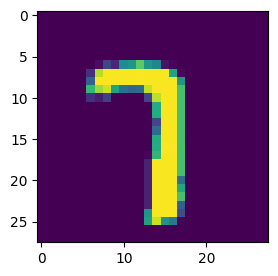

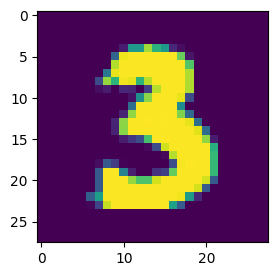

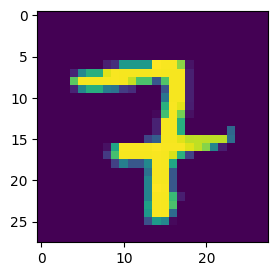

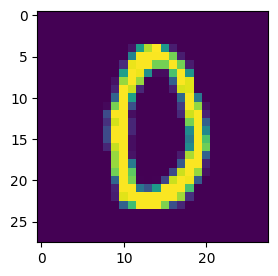

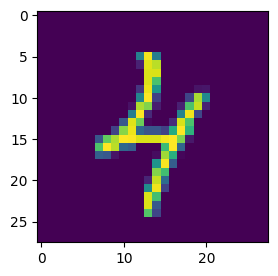

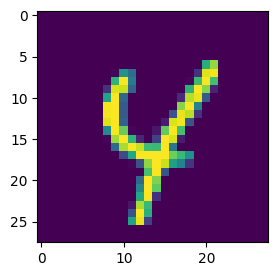

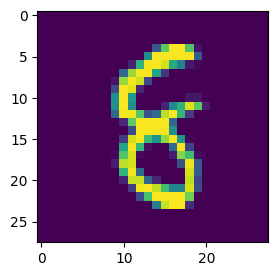

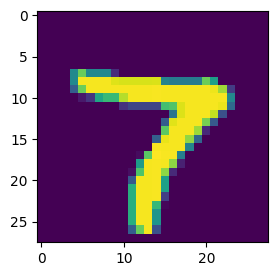

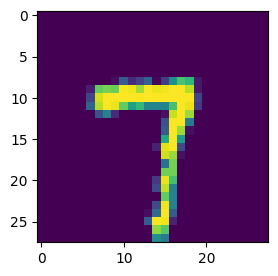

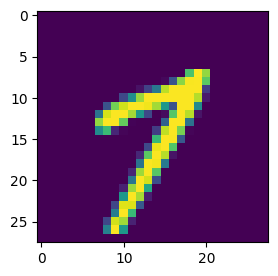

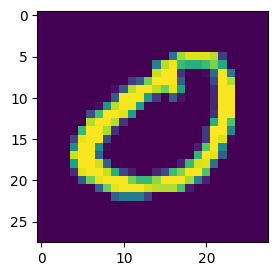

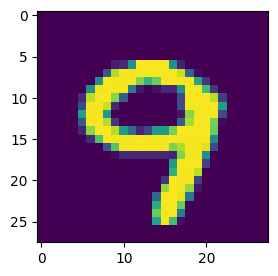

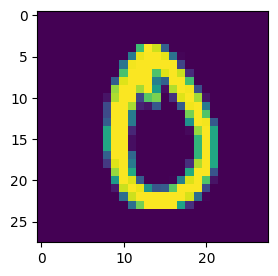

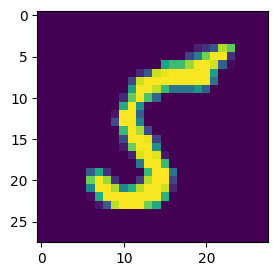

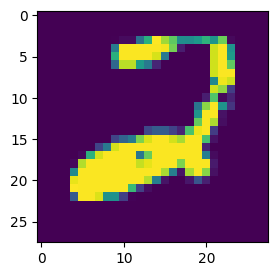

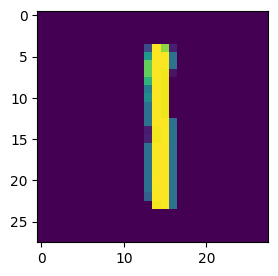

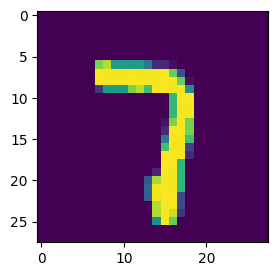

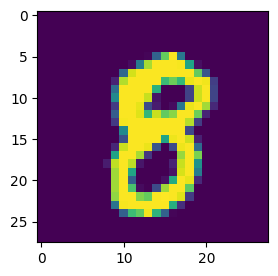

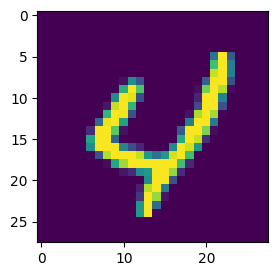

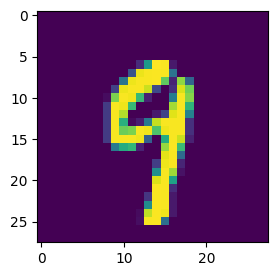

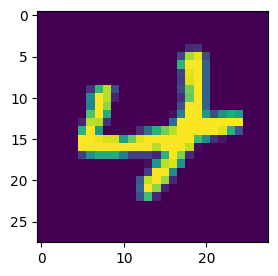

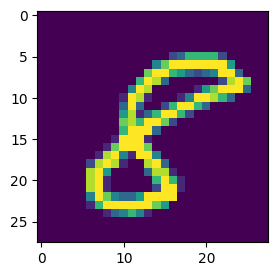

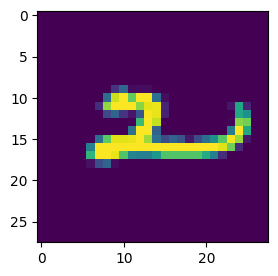

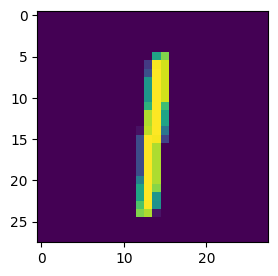

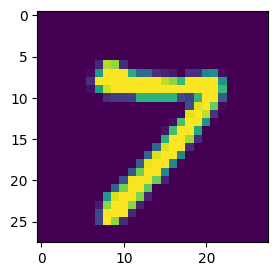

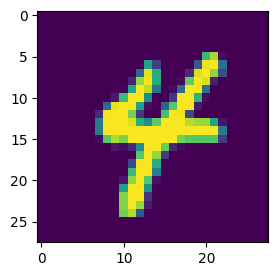

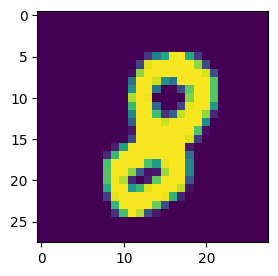

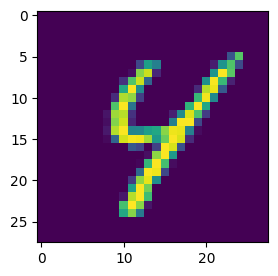

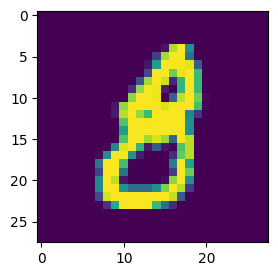

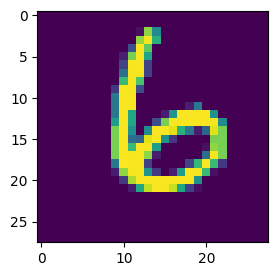

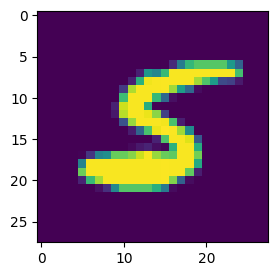

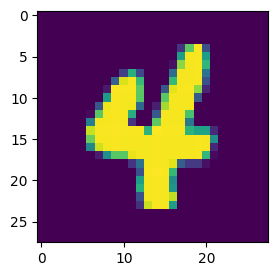

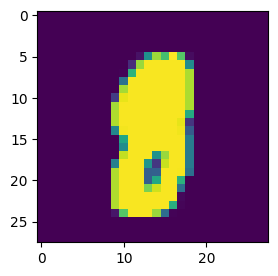

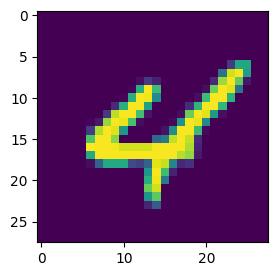

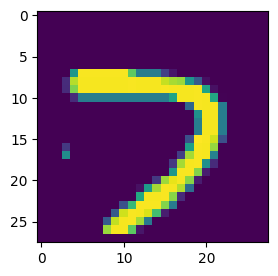

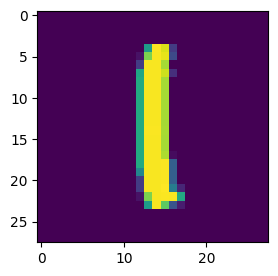

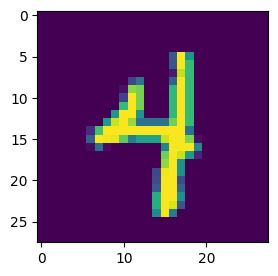

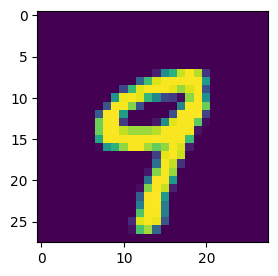

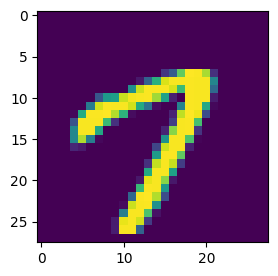

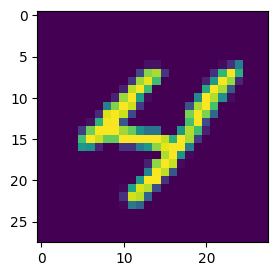

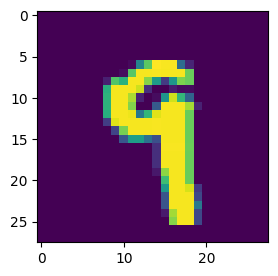

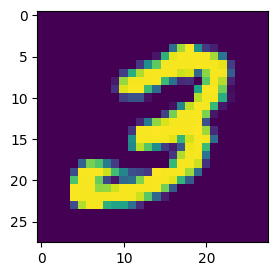

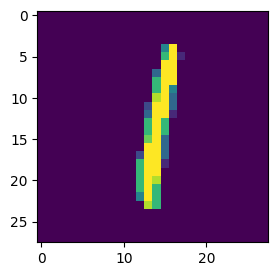

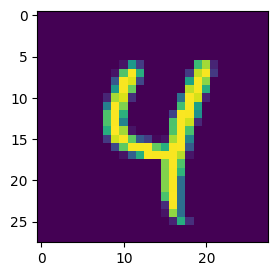

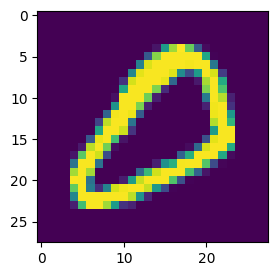

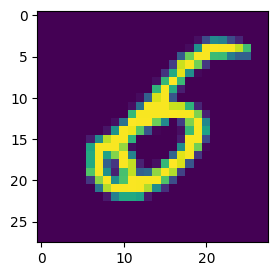

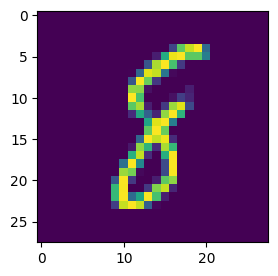

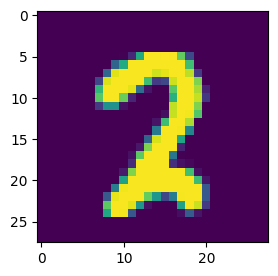

In [20]:
dataiter = iter(test_loader)
for images, labels in dataiter:
    img = images[1]
    fig = plt.figure(figsize=(3, 3))
    plt.imshow(img.reshape((28, 28)))
    print(classes[labels[1].item()])

In [21]:
results = [conv_layers[0](img.to(device))]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer output size: torch.Size([32, 28, 28])
Layer 0 feature maps...


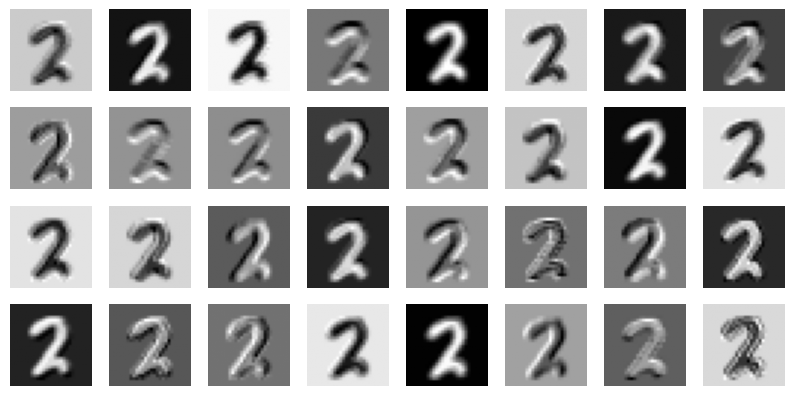

Layer output size: torch.Size([64, 28, 28])
Layer 1 feature maps...


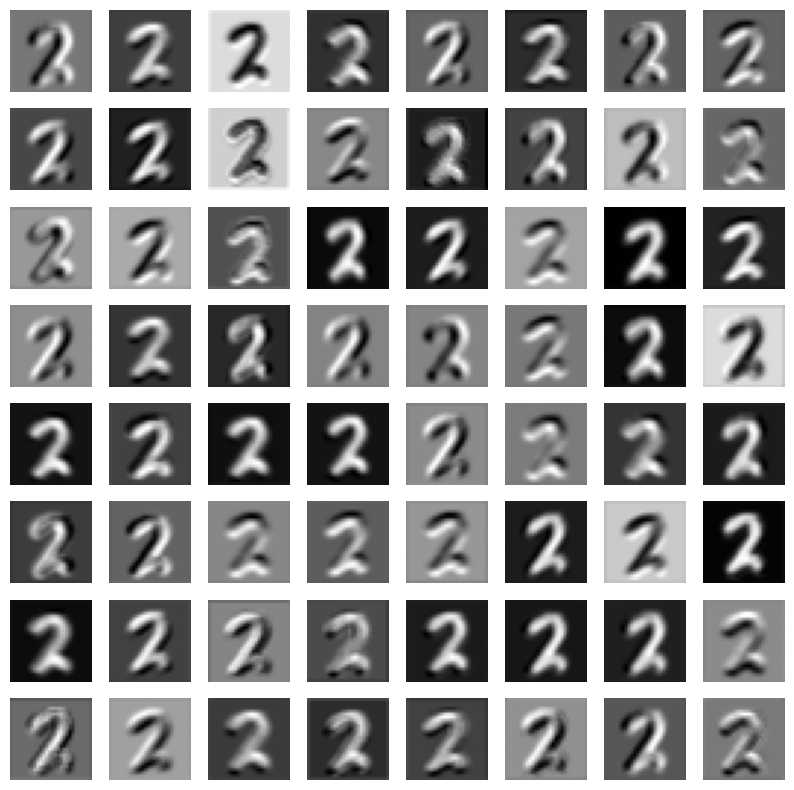

In [22]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(10, 10))
    layer_viz = outputs[num_layer][:, :, :]
    layer_viz = layer_viz.data
    print('Layer output size:', layer_viz.size())
    for i, filter in enumerate(layer_viz):
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu().numpy(), cmap='gray')
        plt.axis("off")
    print(f"Layer {num_layer} feature maps...")
    plt.show()
    plt.close()

In [23]:
import torch
from torch.nn import Conv2d
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [24]:
!curl -L -o 'lotus.jpg' 'https://drive.google.com/uc?export=download&id=1gQSQlrUws22KLRUacXwvN1G8FtIyhfGt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2815  100  2815    0     0   1758      0  0:00:01  0:00:01 --:--:--  9199


In [25]:
def generate_filter(k=3):
  kernel = np.ones((k, k))
  mid_index = k // 2
  kernel[:, mid_index].fill(0)
  kernel[:, mid_index+1:] *= -1
  return kernel

In [26]:
def apply_conv(image, kernel_size, padding=0, stride=1):
  image = torch.from_numpy(image)
  input = image.view((1,1,image.shape[0], image.shape[1]))
  kernel = generate_filter(kernel_size)
  kernel = torch.from_numpy(kernel.astype(np.float32))

  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)
  conv.weight = torch.nn.Parameter(kernel)
  output = conv(input / 255.)
  output_img = output.data.numpy()
  output_img = output_img.reshape((-1, output_img.shape[-1]))

  return output_img

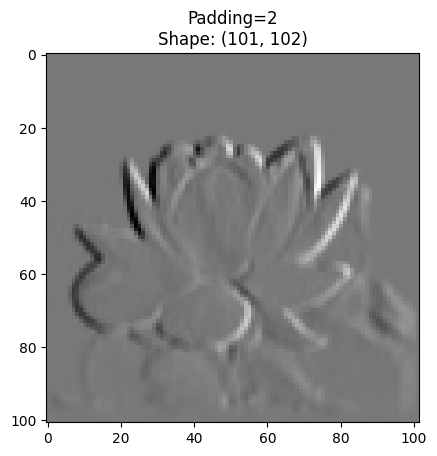

In [27]:
image = cv2.imread('lotus.jpg', 0)

padding = 2
n = apply_conv(image, 3, padding=padding)
plt.imshow(n, cmap='gray')
plt.title('Padding={}\nShape: {}'.format(padding, str(n.shape)))
plt.show()

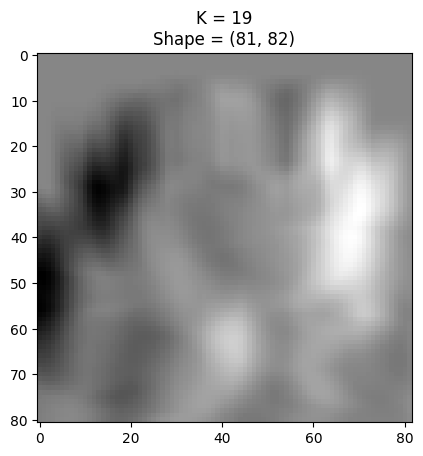

In [28]:
image = cv2.imread('lotus.jpg', 0)
K = 19
n = apply_conv(image, K)

plt.imshow(n, cmap='gray')
plt.title('K = {}\nShape = {}'.format(K, str(n.shape)))
plt.show()

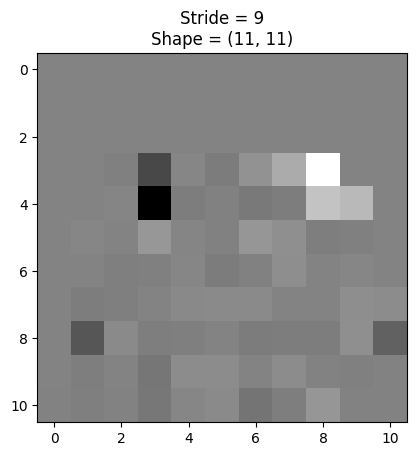

In [29]:
image = cv2.imread('lotus.jpg', 0)

stride = 9
n = apply_conv(image, 3, stride=stride)
plt.imshow(n, cmap='gray')
plt.title('Stride = {}\nShape = {}'.format(stride, str(n.shape)))
plt.show()

Max Pooling:
 [[9. 8.]
 [7. 9.]]

Avg Pooling:
 [[2.5625 3.    ]
 [2.5625 1.9375]]



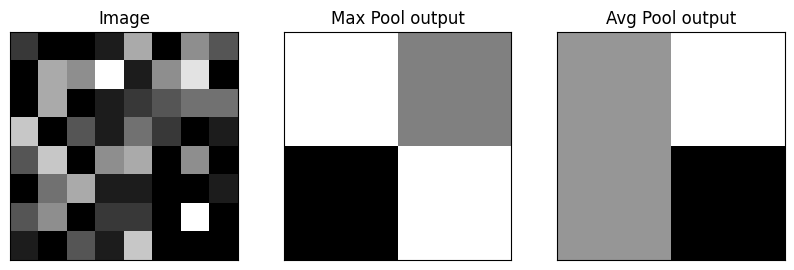

In [31]:
from torch.nn import MaxPool2d, AvgPool2d
import warnings
warnings.filterwarnings('ignore')


def plot_images(images, titles, tick_params=True):
  n = len(images)
  fig = plt.figure(figsize=(10,4))
  for i in range(n):
    ax = fig.add_subplot(1,n,i+1)
    if len(images[i].shape) == 2:
      ax.imshow(images[i], cmap='gray',
                extent=(0,images[i].shape[1], images[i].shape[0], 0))
    else:
      ax.imshow(images[i])
    ax.set_title(titles[i])
    if not tick_params:
      plt.tick_params(axis='both', labelbottom=False, bottom=False,
                labelleft=False, left=False)
  plt.show()
image = np.array([
   		[2, 0, 0, 1, 6, 0, 5, 3],
		[0, 6, 5, 9, 1, 5, 8, 0],
		[0, 6, 0, 1, 2, 3, 4, 4],
		[7, 0, 3, 1, 4, 2, 0, 1],
		[3, 7, 0, 5, 6, 0, 5, 0],
		[0, 4, 6, 1, 1, 0, 0, 1],
		[3, 5, 0, 2, 2, 0, 9, 0],
		[1, 0, 3, 1, 7, 0, 0, 0]])
output = []
titles = []

output.append(image)
titles.append('Image')

image = torch.from_numpy(image.astype(np.float32))
input = image.view((1,1,image.shape[0], image.shape[1]))

pool_layer = MaxPool2d(kernel_size=4, stride=4)
op = pool_layer(input)
max_output_img = op.data.numpy()
max_output_img = max_output_img.reshape((-1, max_output_img.shape[-1]))
print('Max Pooling:\n', max_output_img)
print()
output.append(max_output_img)
titles.append('Max Pool output')
pool_layer = AvgPool2d(kernel_size=4, stride=4)
op = pool_layer(input)
avg_output_img = op.data.numpy()
avg_output_img = avg_output_img.reshape((-1, avg_output_img.shape[-1]))
print('Avg Pooling:\n',avg_output_img)
print()

output.append(avg_output_img)
titles.append('Avg Pool output')

plot_images(output, titles, tick_params=False)

In [32]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [34]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [35]:
!gdown --id 1V7dt70fz_AKRJlttyjnrtFpuJDLXr15x

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1V7dt70fz_AKRJlttyjnrtFpuJDLXr15x
From (redirected): https://drive.google.com/uc?id=1V7dt70fz_AKRJlttyjnrtFpuJDLXr15x&confirm=t&uuid=7c0fedcd-e340-4a39-8b58-82c298596f73
To: /content/german_traffic_signs_dataset.zip
100% 68.2M/68.2M [00:00<00:00, 108MB/s]


In [36]:
!unzip -q german_traffic_signs_dataset.zip

In [37]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(0, translate=(0.3,0.3), shear=5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = ImageFolder('german_traffic_signs_dataset/Train', transform=transform)
testset = ImageFolder('german_traffic_signs_dataset/Test', transform=transform)

In [38]:
val_split = 0.2
indices = np.arange(len(trainset))
np.random.shuffle(indices)
partition = int((1-val_split)*len(trainset))
train_loader = DataLoader(trainset, shuffle=False, sampler=SubsetRandomSampler(indices[:partition]), batch_size=64, num_workers=2)
val_loader = DataLoader(trainset, shuffle=False, sampler=SubsetRandomSampler(indices[partition:]), batch_size=64, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': partition, 'val': len(train_loader.dataset) - partition}

test_loader = DataLoader(testset, shuffle=False, batch_size=64, num_workers=2)

In [39]:
print('Number of training images: ', dataset_sizes['train'])
print('Number of validation images: ', dataset_sizes['val'])
print('Number of test images: ', len(test_loader.dataset))
print('Number of classes: ', len(trainset.classes))

Number of training images:  6880
Number of validation images:  1720
Number of test images:  2000
Number of classes:  43


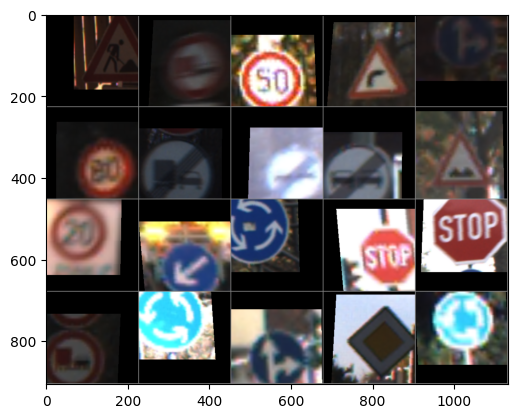

In [40]:
def plot_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(train_loader)
images, labels = next(dataiter)

plot_image(torchvision.utils.make_grid(images[:20], nrow=5))

In [41]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    since = time.time()
    best_acc = 0.0

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              train_losses.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_losses.append(epoch_loss)
              val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc*100))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc*100))

    return train_losses, val_losses, train_acc, val_acc

In [42]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0
    correct = 0
    for i, (images, labels) in enumerate(test_loader):
      with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, preds = torch.max(output, dim=1)
        correct += (preds == labels).sum()

    test_acc = correct / len(test_loader.dataset)
    print('Test Accuracy: {:.4f}'.format(test_acc*100))

In [43]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 43)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 84.5MB/s]


In [44]:
criterion = nn.CrossEntropyLoss()

In [45]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [46]:
test_model(model, test_loader)

Test Accuracy: 2.6500


In [51]:
history = train_model(model, criterion, optimizer, dataloaders, num_epochs=6)

Epoch 0/5
----------
train Loss: 0.0672 Acc: 99.8256
val Loss: 0.0522 Acc: 99.6512

Epoch 1/5
----------
train Loss: 0.0533 Acc: 99.7820
val Loss: 0.0408 Acc: 99.7093

Epoch 2/5
----------
train Loss: 0.0424 Acc: 99.8547
val Loss: 0.0328 Acc: 99.6512

Epoch 3/5
----------
train Loss: 0.0333 Acc: 99.9128
val Loss: 0.0270 Acc: 99.8837

Epoch 4/5
----------
train Loss: 0.0292 Acc: 99.9564
val Loss: 0.0236 Acc: 99.7674

Epoch 5/5
----------
train Loss: 0.0256 Acc: 99.9419
val Loss: 0.0207 Acc: 99.9419

Training complete in 185m 34s
Best val Acc: 99.941860


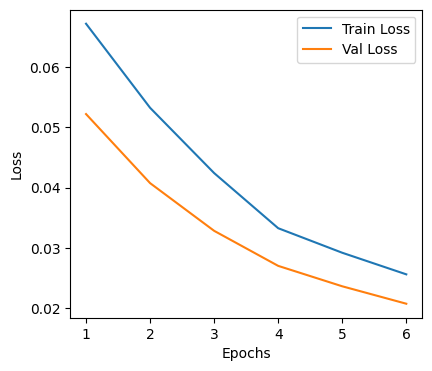

In [52]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'])

In [53]:
test_model(model, test_loader)

Test Accuracy: 91.9500


In [54]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 43)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

In [55]:
print('Before training')
test_model(model_conv, test_loader)

Before training
Test Accuracy: 2.2500


In [56]:
history = train_model(model_conv, criterion, optimizer_conv, dataloaders, num_epochs=5)

Epoch 0/4
----------
train Loss: 2.3149 Acc: 41.0901
val Loss: 1.4534 Acc: 58.4302

Epoch 1/4
----------
train Loss: 1.1702 Acc: 70.2471
val Loss: 0.9695 Acc: 75.3488

Epoch 2/4
----------
train Loss: 0.8867 Acc: 77.1076
val Loss: 0.7742 Acc: 80.4651

Epoch 3/4
----------
train Loss: 0.7561 Acc: 80.2180
val Loss: 0.6822 Acc: 82.8488

Epoch 4/4
----------
train Loss: 0.6520 Acc: 83.5465
val Loss: 0.6438 Acc: 83.4884

Training complete in 62m 50s
Best val Acc: 83.488372


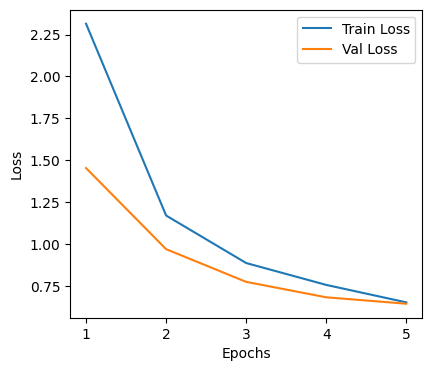

In [57]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'])

In [58]:
test_model(model_conv, test_loader)

Test Accuracy: 46.5500
